# Import libraries

In [144]:
## general
import numpy as np
import pandas as pd
import xarray as xr
import copy
import numpy.ma as ma
from itertools import compress
import joblib
import os
import regionmask
import time 
import geopandas
import cftime

## plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import from_levels_and_colors
from matplotlib.lines import Line2D 
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import mplotutils as mpu
#import seaborn as sns

# extra stuff for Lea's loading codes
import glob
from datetime import datetime

# Define functions

In [145]:
def norm_cos_wgt(lats):
    
    from numpy import cos, deg2rad
    
    return np.cos(np.deg2rad(lats))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [146]:
def load_data_single_mod(gen,model,GMST=False, Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01',usr_time_res="ann"):

    """ Load the all initial-condition members of a single model in cmip5 or cmip6 for given scenario plus associated historical period.

    Keyword argument:
    gen: generation (cmip5 = 5 and cmip6 = 6 are implemented)
    model: model str
    scenario: scenario str
    GMST: decides if wgt Tanglob is computed (and returned) or not, default is not returned
    Tref_all: decides if the Tref at each grid point is dervied based on all available runs or not, default is yes       
    Tref_start: starting point for the reference period with default 1870
    Tref_end: first year to no longer be included in reference period with default 1900

    Output:
    y: the land grid points of the anomalies of the variable on grid centered over 0 longitude (like the srexgrid) 
    time: the time slots
    srex: the gridded srex regions
    df_srex: data frame containing the shape files of the srex regions
    lon_pc: longitudes for pcolormesh (needs 1 more than on grid)
    lat_pc: latitudes for pcolormesh (needs 1 more than on grid)
    idx_l: array with 0 where sea, 1 where land (assumption: land if frac land > 0)
    wgt_l: land grid point weights to derive area weighted mean vars
    Tan_wgt_globmean = area weighted global mean temperature

    """
    print("start with model", model)
        
    var='tas'
    temp_res=usr_time_res
    spatial_res='g025'
        
    ##load in constant files
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_srex = "IPCC-WGII-continental-regions_srex_mask.nc"
        
    # SREX names ordered according to SREX mask
    srex_names = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS','NSA', 'NES', 'SAM', 'SWS', 
              'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED','SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG',
              'RAR','WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA','NAU', 'CAU', 'EAU', 
              'SAU', 'NZ', 'EAN', 'WAN']
    
    # srex_raw nrs from 1-26
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid
    
    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 
    
    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values))[idx_l] # srex indices on land
    print(wgt.shape)
    
    y={}
    T_ref = np.zeros(idx_l.shape)
    run_nrs={}
    
    if GMST == True:
        Tan_wgt_globmean = {}
        Tan_wgt_globmean_hist = {}
        
    if gen == 6:     
        dir_var= '/home/tristan/mesmer_data/CMIP6/tas/%s/g025/'%usr_time_res  #select the correct directory
        
        run_names_list = sorted(glob.glob(dir_var+var+'_'+temp_res+'_'+model+'_ssp*_'+'r*i1p1f*'+'_'+spatial_res+'.nc'))
        run_names_list_historical=sorted(glob.glob(dir_var+var+'_'+temp_res+'_'+model+'_historical_'+'r*i1p1f*'+'_'+spatial_res+'.nc'))
        
        for run_name in run_names_list:
            run_name_ssp = run_name
            
            data = xr.open_mfdataset(run_name_ssp, concat_dim='time', combine="nested").sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
            data = data.assign_coords(lon= (((data.lon + 180) % 360) - 180)) #assign coords so same labels as others
            scen = run_name.split('/')[-1].split('_')[-3]
            run = int(run_name.split('/')[-1].split('_')[-2].split('r')[1].split('i')[0])
            
            if scen not in list(y.keys()):
                y[scen]={}
                run_nrs[scen]=[]
                y[scen][run] = data.tas.values  #still absolute values (contains also sea pixels)
                run_nrs[scen].append(run)
                
            else:
                y[scen][run] = data.tas.values
                run_nrs[scen].append(run)
        
            if GMST == True:
                Tan_wgt_globmean[run] = np.asarray([np.average(y[scen][run][t],weights=wgt) for t in np.arange(y[scen][run].shape[0])])
            
            
        y['historical']={}
        run_nrs['historical']=[]
        for run_name in run_names_list_historical:
            run_name_hist = run_name
            data_hist = xr.open_mfdataset(run_name_hist,concat_dim='time',  combine="nested").sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
            run = int(run_name.split('/')[-1].split('_')[-2].split('r')[1].split('i')[0])
            y['historical'][run] = data_hist.tas.values
            run_nrs['historical'].append(run)
            
        #sum up all ref climates
            T_ref += data_hist.tas.sel(time=slice(Tref_start, Tref_end)).mean(dim='time').values*1.0/len(run_names_list_historical)
            y['historical'][run]=y['historical'][run][:,idx_l]
            
            
    for scen in [i for i in y.keys()]:
        print(scen, run_nrs[scen])
        for run in run_nrs[scen]:
            if Tref_all == True:
                try:
                    y[scen][run]=(y[scen][run]-T_ref)[:,idx_l]
                except:
                    y[scen][run]=(y[scen][run]-T_ref[idx_l])
#                     print('Exception dealth with, ', scen,y[scen][run].shape)
            else:
                try:
                    y[scen][run]=y[scen][run][:,idx_l]
                except:
                    y[scen][run]=y[scen][run]
                    print('No T ref, ', scen,y[scen][run].shape)
                    
#     if (data.lon!=srex_raw.lon).any() and (srex_raw.lon!=frac_l.lon).any():
#         print("There is an error. The grids do not agree.")
    
    time=data["time"]
    time_hist=data_hist["time"]
    
    if GMST == False:
        if Tref_all == False:
            return y,time,time_hist,run_nrs, srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l, T_ref
        else:
            return y,time,time_hist,run_nrs,srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l
    else:
        return y,time,time_hist,run_nrs,srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l,Tan_wgt_globmean

In [147]:
def load_data_obs(obs, Tref_start='1951-01-01', Tref_end='1980-01-01', Tblendglob_idx=False):
    """ Load the observations.

    Keyword argument:
    - obs: currently implemented for "best" and "cowtan"
    - Tref_start: starting point for the reference period with default 1951 (ie BEST Tref)
    - Tref_end: last year still INCLUDED for the reference period with default 1980 (ie BEST Tref) (ATTENTION: different from load_data_single_mod where is the first NOT included)
    - Tblend_idx: whether to compute the blended Tanglob anomaly or not (default = False)

    Output:
    - y: the land grid points of the anomalies of the variable on grid centered over 0 longitude (like the srexgrid) 
    - time: the time slots
    - Tblendglob = area weighted global mean temperature (blend from SST over ocean and tas over land + sea ice)
        
            
    """
    dir_data = '/home/tristan/mesmer/data/'
    
    # read in the land-sea mask
    file_ls = 'interim_invariant_lsmask_regrid.nc' # ERA-interim mask regridded by Richard from 73x144 to 72x144
    frac_l = xr.open_mfdataset(dir_data+file_ls) #land-sea mask of ERA-interim bilinearily interpolated 
    frac_l = frac_l.where(frac_l.lat>-60,0) # remove Antarctica from frac_l field (ie set frac l to 0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idex land #-> everything >0 I consider land

    lons, lats = np.meshgrid(frac_l.lon.values,frac_l.lat.values) # the lon, lat grid (just to derive weights)   
    wgt = norm_cos_wgt(lats) # area weights of each grid point
    
    
    if obs == 'best':
        obs_file='obs_data_25.nc' 
        ds_obs=xr.open_mfdataset(dir_data+obs_file).rename({'temperature':'tas'}).sel(time=slice('1880-01-01', '2022-01-01'))
        time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
        ds_obs['time'] = time
        ds_obs['lon'] = ds_obs['lon']-180
        
    if obs == 'giss':
        file='GISS_tas_g25.nc' 
        ds_obs=xr.open_mfdataset(dir_data+file).rename({'tempanomaly':'tas'}).sel(time=slice('1880-01-01', '2022-01-01')).drop(['time_bnds'])
        time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[M]')
        ds_obs['time'] = time
        ds_obs['lon'] = ds_obs['lon']-180
        
    T_ref = ds_obs.tas.sel(time=slice(Tref_start, Tref_end)).mean(dim='time')
    if Tblendglob_idx == True:
        tas=ds_obs.tas.values-T_ref.values
        Tblendglob=np.zeros(tas.shape[0])
        for t in np.arange(tas.shape[0]):
            idx_valid = ~np.isnan(tas[t])
            Tblendglob[t] = np.average(tas[t,idx_valid],weights=wgt[idx_valid]) #area weighted of available obs -> less data available at beginning        
    
    y=(ds_obs.tas.values-T_ref.values)[:,idx_l]
    time=ds_obs.time.values
    
    if Tblendglob_idx==True:
        return y,time,Tblendglob
    else:
        return y,time

In [148]:
def compute_Tan_wgt_reg(gen,reg,obs_idx=False):
    print(gen,reg)
    
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_obs = "obs_data_25.nc"
    file_srex = "IPCC-WGII-continental-regions_srex_mask.nc"

    df_obs=xr.open_mfdataset(dir_data+file_obs)

    # SREX names ordered according to SREX mask
    srex_names = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS','NSA', 'NES', 'SAM', 'SWS', 
              'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED','SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG',
              'RAR','WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA','NAU', 'CAU', 'EAU', 
              'SAU', 'NZ', 'EAN', 'WAN']
    
    # srex_raw nrs from 1-45
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid
    
    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 
    
    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values))[idx_l]
    
    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
    
    else:   
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex # ATTENTION: not 100% convinced yet if this is correct (I get some missing values that
        idx_reg_l_grid = (srex_grid==idx_reg)#& idx_l 
    
    Tan_wgt_reg_y={}
    Tan_wgt_reg_y_hist={}
    Tan_wgt_reg_y_mean={}
    Tan_wgt_reg_y_mean_hist={}
    Tan_wgt_reg_y_mean_all={}
    x = {}
    
    if gen == 6:
        models_sel = models
    
    for model in models_sel:
        Tan_wgt_reg_y[model]={}
        Tan_wgt_reg_y_hist[model]={}
        
        #### calculate the historical land surface temperature
        for run_nr in np.arange(len(y[model]['historical'])):   
            Tan_wgt_reg_y_hist[model][run_nr] = np.zeros(len(time_hist[model]))
            try:
                for i in np.arange(len(time_hist[model])):
                    Tan_wgt_reg_y_hist[model][run_nr][i] = np.average(y[model]['historical'][run_nr][i][idx_reg_l],weights=wgt_l[idx_reg_l])
        
            except:
                for i in np.arange(len(time_hist[model])):
                    Tan_wgt_reg_y_hist[model][run_nr][i] = np.average(y[model]['historical'][run_nr+1][i][idx_reg_l],weights=wgt_l[idx_reg_l])
        
        
        #### calculate the projected land surface temperature
        for run_nr in np.arange(len(y[model]['ssp585'])):
            Tan_wgt_reg_y[model][run_nr] = np.zeros(len(time[model]))
            try:
                for i in np.arange(len(time[model])):
                    Tan_wgt_reg_y[model][run_nr][i] = np.average(y[model]['ssp585'][run_nr][i][idx_reg_l],weights=wgt_l[idx_reg_l])
            except:
                for i in np.arange(len(time[model])):
                    Tan_wgt_reg_y[model][run_nr][i] = np.average(y[model]['ssp585'][run_nr+1][i][idx_reg_l],weights=wgt_l[idx_reg_l]) 
        
        #### calculate mean TAS values for scen
        x[model] = np.array(list(Tan_wgt_reg_y[model].values()))
        Tan_wgt_reg_y_mean[model] = np.mean(x[model], axis=0)
        
        #### calculate mean TAS values for historical
        x[model] = np.array(list(Tan_wgt_reg_y_hist[model].values()))
        Tan_wgt_reg_y_mean_hist[model] = np.mean(x[model], axis=0)
        
    return Tan_wgt_reg_y, Tan_wgt_reg_y_hist, Tan_wgt_reg_y_mean, Tan_wgt_reg_y_mean_hist, idx_reg_l_grid

In [149]:
def compute_wgt_reg_obs(reg):
    
    dir_data = "/home/tristan/mesmer/data/"
    file_ls = "interim_invariant_lsmask_regrid.nc"
    file_obs = "obs_data_25.nc"
    file_srex = "IPCC-WGII-continental-regions_srex_mask.nc"

    df_obs=xr.open_mfdataset(dir_data+file_obs)

    # SREX names ordered according to SREX mask
    srex_names = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS','NSA', 'NES', 'SAM', 'SWS', 
              'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED','SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG',
              'RAR','WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA','NAU', 'CAU', 'EAU', 
              'SAU', 'NZ', 'EAN', 'WAN']
    
    # srex_raw nrs from 1-45
    srex_raw = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
    lons, lats = np.meshgrid(srex_raw.lon.values,srex_raw.lat.values) #derive the lat, lon grid
    
    #apply land mask
    frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
    frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
    frac_l = frac_l.where(frac_l.lat>-60,0)
    idx_l=np.squeeze(frac_l.lsm.values)>0.0 
    
    wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
    wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
    lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh
    srex = (np.squeeze(srex_raw.srex_mask.values))[idx_l] # srex indices on land

    if reg == 'Global_land':
        idx_reg_l=np.ones(3043,dtype=bool)
        idx_reg_l_grid = copy.deepcopy(idx_l)
        
    else:
        idx_reg = srex_names.index(reg) # index region
        idx_reg_l = (srex==idx_reg) #index land (l) gp inside specific srex region (reg)
        srex_grid=np.zeros(idx_l.shape)
        srex_grid[idx_l]=srex # ATTENTION: not 100% convinced yet if this is correct (I get some missing values that
        idx_reg_l_grid = (srex_grid==idx_reg)#& idx_l 
    
    datasets = ["best", "giss"]
    
    obs_tas_mean = {}
    x = {}
    list_x = {}
    y_mon = {}
    y_ann = {}
    
    for dataset in datasets:
        obs_tas_mean[dataset] = {}
        if dataset == "giss":
            for i in np.arange(len(time_obs)):
                idx_valid=~np.isnan(tas_GISS[i][idx_reg_l])
                obs_tas_mean[dataset][i] = np.average(tas_GISS[i][idx_reg_l][idx_valid],weights=wgt_l[idx_reg_l][idx_valid]) 
    
        if dataset == "best":
            for i in np.arange(len(time_obs)):
                idx_valid=~np.isnan(tas_BEST[i][idx_reg_l])
                obs_tas_mean[dataset][i] = np.average(tas_BEST[i][idx_reg_l][idx_valid],weights=wgt_l[idx_reg_l][idx_valid])
                
        x[dataset] = obs_tas_mean[dataset].items()
        list_x[dataset] = list(x[dataset])
        y_mon[dataset] = np.array(list_x[dataset])[:, -1]
        y_ann[dataset] = pd.DataFrame({"time":time_obs, "tas":y_mon[dataset]}).set_index("time")
        y_ann[dataset] = y_ann[dataset].resample("Y").mean()
        print(dataset, reg)
        
    time = np.arange(np.datetime64('1880-01-01'), np.datetime64('2022-01-01'), dtype='datetime64[Y]')
    return y_mon, y_ann, time

# Load data for regional weighting and land mask

In [150]:
dir_data = "/home/tristan/mesmer/data/"
file_ls = "interim_invariant_lsmask_regrid.nc"
file_obs = "obs_data_25.nc"
file_srex = "IPCC-WGII-continental-regions_srex_mask.nc"

df_obs=xr.open_mfdataset(dir_data+file_obs)

# SREX names ordered according to SREX mask
srex_names = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS','NSA', 'NES', 'SAM', 'SWS', 
              'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED','SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG',
              'RAR','WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA','NAU', 'CAU', 'EAU', 
              'SAU', 'NZ', 'EAN', 'WAN']

print(len(srex_names))

# srex_raw nrs from 1-26
srex = xr.open_mfdataset(dir_data+file_srex, combine='by_coords',decode_times=False) 
lons, lats = np.meshgrid(df_obs.lon.values,df_obs.lat.values) #derive the lat, lon grid

#apply land mask
frac_l = xr.open_mfdataset(dir_data+file_ls, combine='by_coords',decode_times=False) #land-sea mask
frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))
frac_l = frac_l.where(frac_l.lat>-60,0)
idx_l=np.squeeze(frac_l.lsm.values)>0.0 
 
wgt = np.cos(np.deg2rad(lats)) # area weights of each grid point
wgt_l = (wgt*frac_l_raw)[idx_l] # area weights for land grid points (including taking fraction land into consideration)
lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat) # the lon / lat for the plotting with pcolormesh

print(wgt.shape)

46
(72, 144)


## Define the set of models

In [151]:
models = ['ACCESS-CM2','ACCESS-ESM1-5','BCC-CSM2-MR','CAMS-CSM1-0','CanESM5','CAS-ESM2-0', 'CESM2-WACCM', 'CESM2', 'CMCC-CM2-SR5',
          'CNRM-CM6-1','CNRM-CM6-1-HR','CNRM-ESM2-1', 'EC-Earth3','EC-Earth3-Veg', 'FGOALS-f3-L','FGOALS-g3',
         'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8','INM-CM5-0',
          'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MIROC6','MIROC-ES2L', 'MPI-ESM1-2-HR',
          'MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL']  
    
    
print(len(models))

36


## Use the loading function to load parameters for each model

In [152]:
y = {}
time = {}
run_nrs_tas = {}
time = {}
time_hist={}
wgt_l={}

for model in models:
    y[model],time[model],time_hist[model],run_nrs_tas[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l = load_data_single_mod(6,model,GMST=False,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01', usr_time_res="ann")
    
for scen in y[model].keys():
    y[model][scen]=np.stack(([y[model][scen][run] for run in run_nrs_tas[model][scen]]))


start with model ACCESS-CM2
(72, 144)
ssp585 [1, 2, 3, 4, 5]
historical [1, 2, 3, 4, 5]
start with model ACCESS-ESM1-5
(72, 144)
ssp585 [1, 2, 3, 4, 5, 6, 7, 8, 9]
historical [1, 2, 3, 4, 5, 6, 7, 8, 9]
start with model BCC-CSM2-MR
(72, 144)
ssp585 [1]
historical [1, 2, 3]
start with model CAMS-CSM1-0
(72, 144)
ssp585 [1, 2]
historical [1, 2]
start with model CanESM5
(72, 144)
ssp585 [1, 2, 3, 4, 5, 6, 7, 8, 9]
historical [1, 2, 3, 4, 5, 6, 7, 8, 9]
start with model CAS-ESM2-0
(72, 144)
ssp585 [1, 3]
historical [1, 2, 3, 4]
start with model CESM2-WACCM
(72, 144)
ssp585 [1, 2, 3]
historical [1, 2, 3]
start with model CESM2
(72, 144)
ssp585 [1, 2, 4]
historical [1, 2, 3, 4, 5, 6, 7, 8, 9]
start with model CMCC-CM2-SR5
(72, 144)
ssp585 [1]
historical [1]
start with model CNRM-CM6-1
(72, 144)
ssp585 [1, 2, 3, 4, 5, 6]
historical [1, 2, 3, 4, 5, 6, 7, 8, 9]
start with model CNRM-CM6-1-HR
(72, 144)
ssp585 [1]
historical [1]
start with model CNRM-ESM2-1
(72, 144)
ssp585 [1, 2, 3, 4, 5]
histor

## Calculate the weighted land surface temperature for specific region  for each run and across all runs

In [153]:
reg = 'Global_land'
LST = {}
LST_hist = {}

LST, LST_hist, LST_mean, LST_hist_mean, idx_l_reg_gl = compute_Tan_wgt_reg(6, reg)

6 Global_land


In [154]:
reg = 'WNA'
LST_WNA = {}
LST_hist_WNA = {}

LST_WNA, LST_hist_WNA, LST_mean_WNA, LST_hist_mean_WNA, idx_l_reg_WNA = compute_Tan_wgt_reg(6, reg)

6 WNA


In [155]:
reg = 'WSAF'
LST_WSAF = {}
LST_hist_WSAF = {}

LST_WSAF, LST_hist_WSAF, LST_mean_WSAF, LST_hist_mean_WSAF, idx_l_reg_WSAF = compute_Tan_wgt_reg(6, reg)

6 WSAF


In [165]:
reg = 'SAS'
LST_SAS = {}
LST_hist_SAS = {}

LST_SAS, LST_hist_SAS, LST_mean_SAS, LST_hist_mean_SAS, idx_l_reg_SAS = compute_Tan_wgt_reg(6, reg)

6 SAS


## Load in observation data

In [157]:
#### load monthly tas for each grid point ########################################
datasets = ["best", "giss"]
reg = 'Global_land'

tas_BEST, time_obs = load_data_obs("best")
tas_GISS, time_obs = load_data_obs("giss")


### compute weighted mean TAS across all land surface gridpoints ####################

obs_mon, obs_ann, time_obs_ann = compute_wgt_reg_obs(reg)

best Global_land
giss Global_land


In [158]:
### compute weighted mean TAS for WNA ####################

reg = 'WNA'

obs_mon_WNA, obs_ann_WNA, time_obs_ann = compute_wgt_reg_obs(reg)

best WNA
giss WNA


In [159]:
### compute weighted mean TAS for WSAF ####################

reg = 'WSAF'

obs_mon_WSAF, obs_ann_WSAF, time_obs_ann = compute_wgt_reg_obs(reg)

best WSAF
giss WSAF


In [166]:
### compute weighted mean TAS for SAS ####################

reg = 'SAS'

obs_mon_SAS, obs_ann_SAS, time_obs_ann = compute_wgt_reg_obs(reg)

best SAS
giss SAS


## Plot the results of the ESM runs

In [161]:
### set plot params

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
          'figure.figsize': (9,5),
          "font.family": "serif",
         'ytick.labelsize':'x-large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

In [162]:
v_srex=np.array([-0.5,0.5,1.5]) # to mark which SREX region

cmap_srex, norm_srex = from_levels_and_colors(v_srex, colors=['white','#31a354'], extend='neither')
srex = xr.open_mfdataset('/home/tristan/mesmer/data/IPCC-WGII-continental-regions_srex_mask.nc', combine='by_coords',decode_times=False)
dir_srex_shape='/home/tristan/mesmer_data/srex/ATLAS/reference-regions/IPCC-WGI-reference-regions-v4.shp'

df_all_regs = geopandas.read_file(dir_srex_shape)

srex_names = ['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR', 'NWS','NSA', 'NES', 'SAM', 'SWS', 
              'SES', 'SSA', 'NEU', 'WCE', 'EEU', 'MED','SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF', 'MDG',
              'RAR','WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS', 'ARP', 'SAS', 'SEA','NAU', 'CAU', 'EAU', 
              'SAU', 'NZ', 'EAN', 'WAN']

df_all_regs

df_srex = df_all_regs.loc[df_all_regs['Acronym'].isin(srex_names)] # alternative indexing: search in column Acronym for names

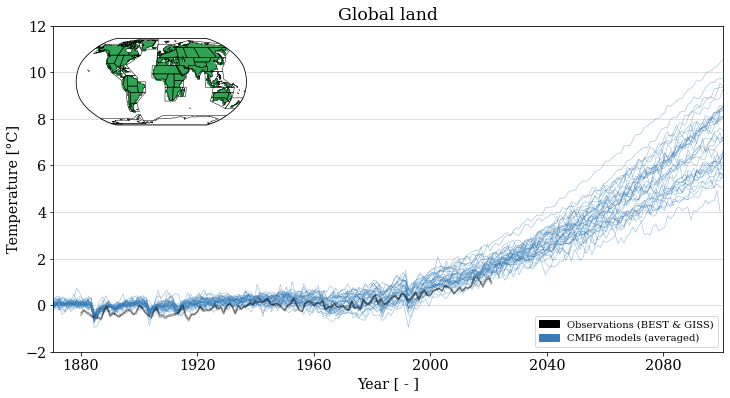

In [163]:
LST_all = {}

time_all = pd.date_range('1870-01-01', '2100-01-01', freq='YS')
time_all = time_all + pd.Timedelta(26, unit='w') - pd.Timedelta(1, unit='d')

fig=plt.figure(figsize=(12,6))

### set boundaries for y-axis
y_min = -2.0
y_max = 12.0
plt.ylim([y_min,y_max])

##create legend
obs_lg = mpatches.Patch(color="k", label="Observations (BEST & GISS)")
runs_lg = mpatches.Patch(color="#377eb8", label="CMIP6 models (averaged)")


for model in models:
        LST_all[model] = np.concatenate((LST_hist_mean[model], LST_mean[model]))
        plt.plot(time_all, LST_all[model], color='#377eb8',lw=0.5,alpha=0.6)

for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann[dataset]['tas'], color="k", alpha=0.35)

plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Global land')
plt.xlabel('Year [ - ]')
plt.ylabel('Temperature [°C]')
leg = plt.legend(handles=[obs_lg,runs_lg], loc="lower right", prop={'size': 10})

ax_sub = fig.add_axes([0.15, 0.65, 0.2, 0.2],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_gl, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

plt.show()

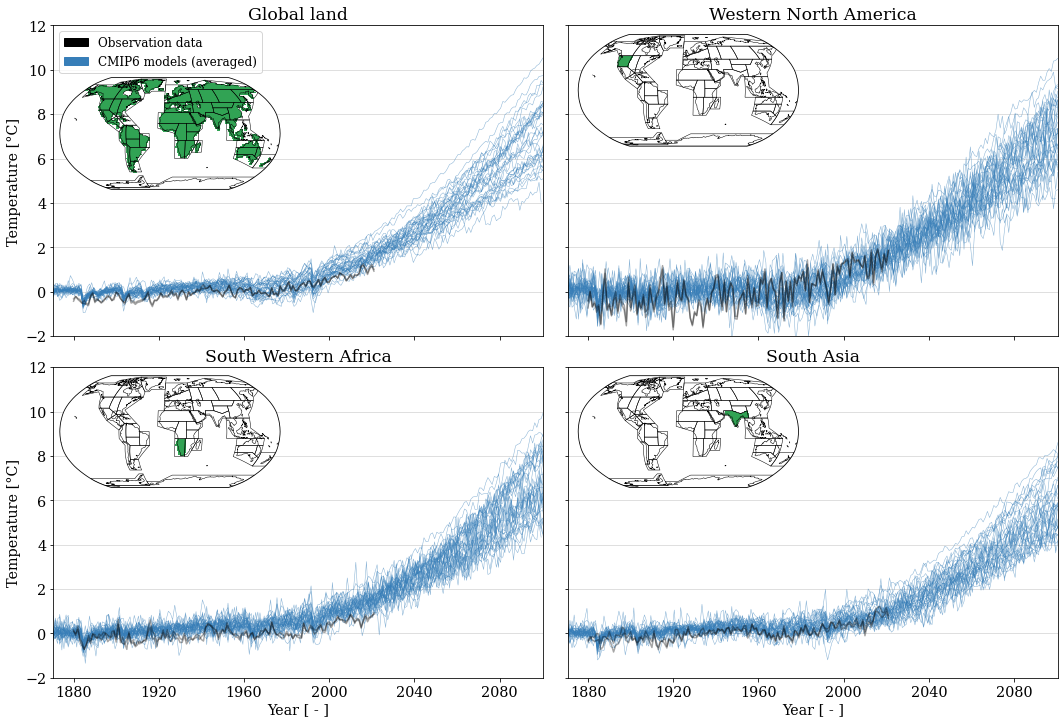

In [168]:
LST_all = {}
LST_all_WNA = {}
LST_all_WSAF = {}
LST_all_SAS = {}

time_all = pd.date_range('1870-01-01', '2100-01-01', freq='YS')
time_all = time_all + pd.Timedelta(26, unit='w') - pd.Timedelta(1, unit='d')

fig=plt.figure(figsize=(18,12))
grid = plt.GridSpec(2, 2, wspace=0.05, hspace=0.1) # create a grid for the subplots

y_min = -2.0
y_max = 12.0

############ plot ax 1 (global land) ##########################
ax1 = plt.subplot(grid[0,0])
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.ylim([y_min,y_max])
for model in models:
        LST_all[model] = np.concatenate((LST_hist_mean[model], LST_mean[model]))
        plt.plot(time_all, LST_all[model], color='#377eb8',lw=0.5,alpha=0.6)
for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann[dataset]['tas'], color="k", alpha=0.35)
        
plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Global land')
plt.ylabel('Temperature [°C]')

## create legend patches
obs_lg = mpatches.Patch(color="k", label="Observation data")
runs_lg = mpatches.Patch(color="#377eb8", label="CMIP6 models (averaged)")
leg = plt.legend(handles=[obs_lg,runs_lg], loc="upper left", prop={'size': 12})

ax_sub = fig.add_axes([0.13, 0.67, 0.17, 0.17],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_gl, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)



############## plot ax2 (WNA) ###################################
ax2 = plt.subplot(grid[0,1])
plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
plt.ylim([y_min,y_max])

for model in models:
        LST_all_WNA[model] = np.concatenate((LST_hist_mean_WNA[model], LST_mean_WNA[model]))
        plt.plot(time_all, LST_all_WNA[model], color='#377eb8',lw=0.5,alpha=0.6)
        
for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann_WNA[dataset]['tas'], color="k", alpha=0.35)
    
plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('Western North America')

ax_sub = fig.add_axes([0.53, 0.72, 0.17, 0.17],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_WNA, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

################# plot ax3 (WSAF) ##################################
ax3 = plt.subplot(grid[1,0])
plt.ylim([y_min,y_max])

for model in models:
        LST_all_WSAF[model] = np.concatenate((LST_hist_mean_WSAF[model], LST_mean_WSAF[model]))
        plt.plot(time_all, LST_all_WSAF[model], color='#377eb8',lw=0.5,alpha=0.6)
        
for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann_WSAF[dataset]['tas'], color="k", alpha=0.35)
    
plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('South Western Africa')
plt.xlabel('Year [ - ]')
plt.ylabel('Temperature [°C]')

ax_sub = fig.add_axes([0.13, 0.325, 0.17, 0.17],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_WSAF, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

############## plot ax4 (SAS) ########################################
ax4 = plt.subplot(grid[1,1])
plt.ylim([y_min,y_max])
plt.xlabel('Year [ - ]')
plt.gca().yaxis.set_major_formatter(plt.NullFormatter())

for model in models:
        LST_all_SAS[model] = np.concatenate((LST_hist_mean_SAS[model], LST_mean_SAS[model]))
        plt.plot(time_all, LST_all_SAS[model], color='#377eb8',lw=0.5,alpha=0.6)

for dataset in datasets:
    plt.plot(time_obs_ann, obs_ann_SAS[dataset]['tas'], color="k", alpha=0.35)        
plt.margins(0,0)
plt.grid(axis='y', alpha=0.5)
plt.title('South Asia')
plt.xlabel('Year [ - ]')

ax_sub = fig.add_axes([0.53, 0.325, 0.17, 0.17],projection=ccrs.Robinson(central_longitude=0))
mesh_srex = ax_sub.pcolormesh(lon_pc, lat_pc, idx_l_reg_SAS, cmap=cmap_srex,norm=norm_srex,transform=ccrs.PlateCarree(),rasterized=True)
ax_sub.coastlines(lw=0.5)
ax_sub.add_geometries(df_srex.geometry.values, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k',lw=0.5)

plt.show()

# Box plots

In [23]:
LST_mean

{'ACCESS-CM2': array([1.30290621, 1.41273877, 1.46403908, 1.62800411, 1.7733718 ,
        1.57063457, 1.802764  , 1.87806423, 1.9508767 , 2.02130392,
        1.90984296, 2.05719866, 2.12111245, 2.1737988 , 2.06237455,
        2.19063668, 2.44278099, 2.22522005, 2.28515907, 2.48460499,
        2.50115164, 2.54751118, 2.6054533 , 2.76000752, 2.64586098,
        2.67611894, 2.8599354 , 2.82028629, 3.0257065 , 2.92229753,
        3.04198576, 3.10738356, 3.16379912, 3.27077758, 3.4381825 ,
        3.62203475, 3.52826017, 3.65895133, 4.0411788 , 3.96410456,
        4.04755018, 4.10192444, 4.31570227, 4.32844609, 4.38798169,
        4.42043104, 4.61418644, 4.68405115, 4.70714776, 4.88070482,
        4.61786279, 4.88633371, 5.19202135, 4.93247225, 5.27445151,
        5.25735484, 5.62847795, 5.38963964, 5.48868852, 5.77560754,
        5.87566352, 5.90490748, 5.9859131 , 5.77723643, 6.05037133,
        6.37338586, 6.39300393, 6.42445323, 6.51765925, 6.79156364,
        6.79641978, 6.79362624, 7.

In [24]:
np.nanmean(list(LST_mean.values()))

4.097313056798612

In [25]:
## first take average of all ESM ssp585 runs on global scale

l = list(iter(LST_mean.values()))
l

ESM_mean = np.zeros(len(LST_mean[model]))

for i in range(len(LST_mean)):
    for j in range(len(LST_mean[model])):
        ESM_mean[j] = np.mean(l[i][j])
        
## take average of all ESM historical runs on global scale

k = list(iter(LST_hist_mean.values()))
k

ESM_mean_hist = np.zeros(len(LST_hist_mean[model]))

for i in range(len(LST_hist_mean)):
    for j in range(len(LST_hist_mean[model])):
        ESM_mean_hist[j] = np.mean(k[i][j])
        
df = pd.DataFrame(ESM_mean_hist)
df1 = pd.DataFrame(ESM_mean)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

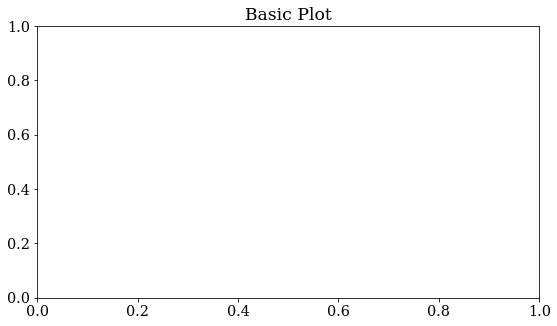

In [26]:
fig, ax = plt.subplots()
ax.set_title('Basic Plot')
ax.boxplot(df, df1)
plt.show()